In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import time, requests 

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


# [Max-cut problem][1]

Given an undirected graph $\mathcal{G=(V,E)}$, where $\mathcal{V}$ is the set of nodes and $\mathcal{E}$ is the set of edges, the max-cut problem asks to partition $\mathcal{V}$ into two disjoint sets, say $\mathcal{S}$ and $\mathcal{T}$, such that the sum of the weights of the edges---called the cut value---of edges between $\mathcal{S}$ and $\mathcal{T}$ maximized. 



$\text{cut value} =\sum_{i<j} w_{ij}\frac{1-z_i z_j}{2} = \frac{1}{2}(\text{total weight} - E)$

$\text{total weight} = \sum_{i<j} w_{ij}$ is a constant.

$E = \text{energy}(\textbf{z}) = \sum_{i<j} w_{ij}z_i z_j$ is an energy of a spin glass (Ising) model.

Maximization of the $\text{cut value}$ is equivalent to minimization of the energy $E$, see [A. Lucas, Ising formulations of many NP problems, Front. Physics 2:5 (2014).][2], 
over the dichotomic variables $z_i = +1,-1$ if the node $i\in \mathcal{S}, \mathcal{T}$, respectively.



The max-cut problem has important applications in various fields, including computer vision, statistical physics, and computational biology. It is also known to be NP-hard, which means that it is computationally difficult to solve optimally for large instances of the problem. Therefore, various approximation algorithms and heuristics have been developed to tackle the problem.


[1]:https://en.wikipedia.org/wiki/Maximum_cut


[2]:https://doi.org/10.3389/fphy.2014.00005


## loading a Gset from the website into the directory

In [2]:
instance = 14


url = f'https://web.stanford.edu/~yyye/yyye/Gset/G{instance}'
r = requests.get(url)                           # create HTTP response object 'r'

with open(f'G{instance}','wb') as f:            # file name = G{instance}
    f.write(r.content)                          # write the contents of r into a new file in binary mode


## loading a Gset into this notebook

In [3]:
instance = 14
Gset_file = open(f'G{instance}','r')

#-------------------------------------------------------------------------------------------------

Edges = []

for i, line in enumerate(Gset_file):     # i = position of line
    row_string = line[:-1].split(' ')    # read the line up to the end (-1) and split as per the space ' '
    if i==0:
        n = int(row_string[0])           # Total number of z-variables 
        num_edges =int(row_string[1])    # Total number of edges
    else:
        row_list = [int(row_string[0]), int(row_string[1]), int(row_string[2])]
        Edges.append(row_list)
        
Edges = np.array(Edges) 

#-------------------------------------------------------------------------------------------------

print(f'{Edges} = collection of the edges with non-zero weights in the last column')
print(Edges.shape, '\n')


print('Is num_edges == len(G): ', num_edges == len(Edges))

W_total = np.sum(Edges[:, -1]) # the last column carries weight for each edge


print('number of nodes (z-variables) = n =', n) 
print('number of edges (non-zero weights) =', num_edges)
print('Total weight =', W_total)


[[  1   7   1]
 [  1  10   1]
 [  1  12   1]
 ...
 [760 771   1]
 [762 765   1]
 [773 792   1]] = collection of the edges with non-zero weights in the last column
(4694, 3) 

Is num_edges == len(G):  True
number of nodes (z-variables) = n = 800
number of edges (non-zero weights) = 4694
Total weight = 4694


## Weight matrix 

In [4]:
W = np.zeros((n,n))                             # initalization W

for i in range(num_edges):
    W[Edges[i,0]-1, Edges[i,1]-1] = Edges[i,2]  #-1 because, in python counting starts from 0, 1, 2, ... 



#---------------------------------------------

print(f'{W} = W\n')
print('A sanity check :', (W.sum()).item() == W_total )
print('Is W == W.T symmetric matrix:', np.mean(W == W.T)==1)


W = torch.tensor(W, dtype=torch.float)

[[0. 1. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] = W

A sanity check : True
Is W == W.T symmetric matrix: False


## Graph

In [ ]:
def graph(color):
    plt.subplots(figsize=(20,20))
    plt.title(f'Gset : G{instance}', fontsize=20)
    np.random.seed(0)
    Gra = nx.Graph()
    Gra.add_nodes_from(list(np.arange(n)+1))
    Gra.add_edges_from([tuple(e[:-1]) for e in Edges])
    nx.draw(Gra, node_size=40, node_color=color) # with_labels=True,
    

graph('Magenta')


## energy (loss) function

In [ ]:
def energy(z):                               # z has n components, each one is either +1 (spin-up) or -1(spin-down)
    E = torch.linalg.multi_dot([z, W, z])    # = energy for a given z
    return E


# Minimizer Neural Network (MNN)

We are using Multi-Layer Perceptron (MLP) as our Minimizer Neural Network. The MLP takes an $m$-component learnable vector $\textbf{x}$ as input, passes it through $L$ layers with learnable parameters 
$\boldsymbol{\theta}:=\{\theta^{[1]},\cdots,\theta^{[L]}\}$, and gives an
$n$-component output vector $\textbf{z}$. Each component of $\textbf{z}$ lies in the interval 
$[-1, 1]$. As a whole, Multi-Layer Perceptron acts as a continuous (differentiable) function 

$f: \mathbb{R}^K \longrightarrow [-1,1]$ such that

$f(\textbf{x},\boldsymbol{\theta})=\textbf{z}$ and $K$ is the total number of learnable parameters.

We feed the output $\textbf{z}$ into the $\text{loss}(\textbf{x},\boldsymbol{\theta})=\text{energy}(\textbf{z})$ and minimize it with Adam optimizer.
After minimization, we got $\textbf{z}_{\text{out}}$, whose components we map to discrete values as

$z \longrightarrow 1$ and $-1$ for $z>0$ and $z\leq0$, respectively

to achieve a max-cut solution (displayed by the graph below).



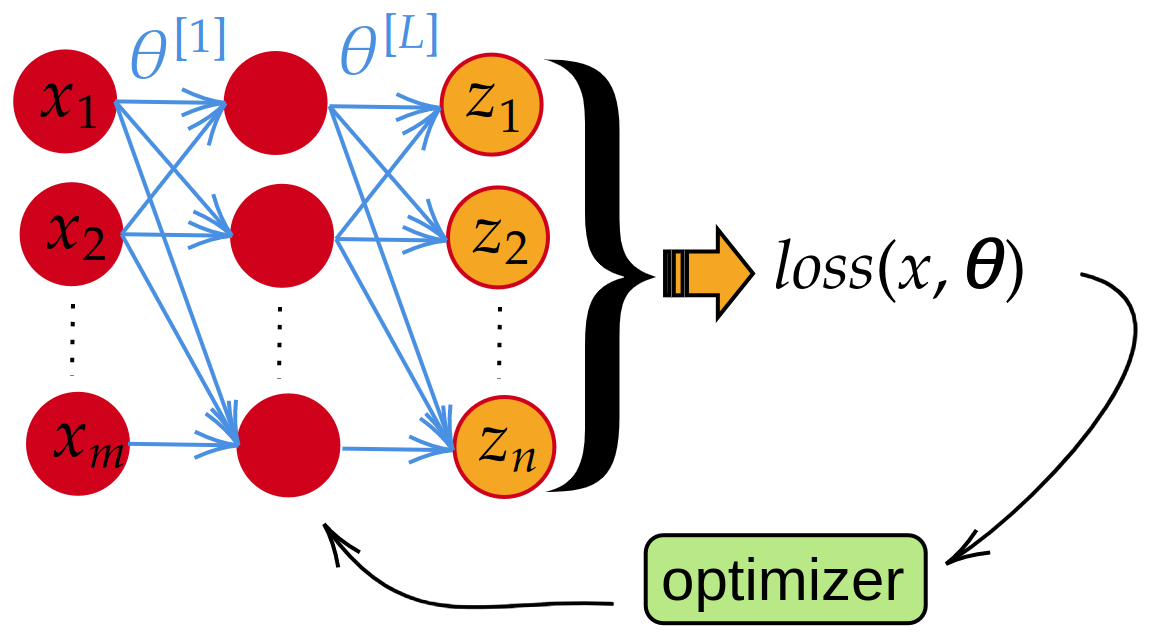

In [ ]:

class minimizer(torch.nn.Module):                  # Define a minimizer
    def __init__(self):
        super().__init__()
        
        x = torch.empty(n, dtype=torch.float)
        torch.nn.init.uniform_(x, -1e-5, 1e-5)
        self.x = torch.nn.Parameter(x)              # it makes x learnable parameters
        
        self.stack_of_layers = nn.Sequential(
            nn.Linear(n, n),
            nn.Tanh()
        )

    def forward(self):
        x = self.stack_of_layers(self.x)
        return x  

## NN training...

In [ ]:
%%time

mini = minimizer()                                                                 # start minimizer instance
optimizer = torch.optim.Adam(mini.parameters(), lr=0.001, weight_decay=1e-3)       # Define optimizer


def extremizing_fn():
    mini.train()
    optimizer.zero_grad()        # Clear gradients
    z = mini()                   # Perform a single forward pass, output = z in [-1,1]
    loss = energy(z)
    loss.backward()              # Derive gradients
    optimizer.step()             # Update parameters based on gradients
    return loss, z


LOSS = []
for epoch in range(0, 101):
    loss, z = extremizing_fn()
    LOSS.append(loss.detach())
    if epoch % 10 == 0: print(f'epoch: {epoch:4d}     loss (energy) ={loss: 3f}')

LOSS = np.array(LOSS)


print()

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(LOSS)
plt.ylabel(r'loss (energy)', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.title(f'Gset = G{instance}  (n = {n})')
plt.show()

## Max-cut solution

After minimization, we got $\textbf{z}_{\text{out}}$, whose components we map to discrete values as

$z \longrightarrow 1$ and $-1$ for $z>0$ and $z\leq0$, respectively

to achieve a max-cut solution (displayed by the graph below).

In [ ]:
z_out = z.detach()
z_out = 2*torch.heaviside(z_out, torch.tensor([0.0]))-1 

#print(f'{z_out} = achieved Max-cut solution')

In [ ]:
color = []
for z in z_out:
    if z==1:
        color.append('red')  # subset S = {nodes in red color}
    else:
        color.append('blue') # subset T = {nodes in blue color}

#----------------------------------------------------------------------       

print('Achieved Max-cut solution:')
graph(color)


## Min energy and Max-cut value

In [ ]:
eng_out = energy(z_out).item()
max_cut_val = (W_total - eng_out)/2

#----------------------------------------------------------------------------------
print(f'Gset = G{instance}')
print(f'achieved minimum loss (energy) = {eng_out}\n')

print(f'achieved max cut value = {max_cut_val}\n')

print('number of nodes (z-variables) = n =', n) 
print('number of edges (non-zero weights) =', num_edges)
print('Total weight =', W_total)

In [ ]:
'Best known max cut value for G14 = 3064 given in https://www.sciencedirect.com/science/article/abs/pii/S0952197612002175'
